# Dataset

In [1]:
from pandas import read_csv, DataFrame, get_dummies, cut
from numpy import nan, mean, percentile, where, float32, empty, zeros
from matplotlib.pyplot import subplots
from seaborn import barplot, despine
from scipy.sparse import csr_matrix
from sparse_dot_topn import awesome_cossim_topn
from gc import collect

from IPython.display import clear_output

In [2]:
# From: https://datasets.imdbws.com
reviews_og = read_csv('./data/reviews.tsv', sep='\t')
titles_og = read_csv('./data/titles.tsv', sep='\t', low_memory=False)
title_extra_og = read_csv('./data/titles_extra_info.tsv', sep='\t', low_memory=False)

## Cleaning

### Titles

In [3]:
# Only pull movies
movies = titles_og[titles_og['titleType'] == 'movie']

# Input NaN where appropriate
movies = movies.replace('\\N', nan)

# Clean up dtypes
movies['isAdult'] = movies['isAdult'].astype(int)
movies['startYear'] = movies['startYear'].astype("Int64")
movies['runtimeMinutes'] = movies['runtimeMinutes'].astype("Int64")

# Drop endYear - always blank for movies
movies = movies.drop(columns=['endYear', 'originalTitle'])

# Get region information
regions = title_extra_og[['titleId', 'region']]
regions = regions[regions['region'] == 'US'].drop_duplicates()

# Add region information to movies
movies = movies[movies['tconst'].isin(regions['titleId'])]

In [4]:
movies.head()

,tconst,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,0,1894,45,Romance
570,tt0000574,movie,The Story of the Kelly Gang,0,1906,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,0,1907,90,Drama
625,tt0000630,movie,Hamlet,0,1908,<NA>,Drama
672,tt0000679,movie,The Fairylogue and Radio-Plays,0,1908,120,"Adventure,Fantasy"


### Reviews

In [5]:
# Only keep reviews for movies
reviews = reviews_og[reviews_og['tconst'].isin(movies['tconst'])]

In [6]:
reviews.head()

,tconst,averageRating,numVotes
8,tt0000009,5.2,200
357,tt0000574,6.0,791
364,tt0000591,5.1,20
385,tt0000630,2.9,25
417,tt0000679,5.2,66




For any machine learning problems, we need a baseline model or method to use as a reference whether our approach is good or not.

Our machine learning prediction or sophsticated analysis should, at least, beat those baseline performance.

For recommendation system, we can make a simple baseline score with popular item recommendation

To define the popularity of the item, there have a metrics called weighted rating system that is used to score the rating of each movie.

Here is the formula

```
(WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C
```
Where
- R = average rating for the movie. (rating)
- v = number of votes for the movie. (members)
- m = minimum votes required to be listed in the Top 250 (defined by > percentile 80 of total votes)
- C = the average rating across the whole dataset.

**Drawback**

- It's not personalized. All the users will get the same exact list of popularity based recommendation.

**Action**

- For new users, if we don't have any information about them we can provide the list based on ranking the vote_count or weighted_rating as a best guess.
In real world, this is the result when you see the section "Popular on Netflix"

**Reference**

- [IMDB rating system](https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV?ref_=helpms_helpart_inline#)

## Popularity-based

The simpliest approach to recommendations (and typically the first recommendations when a system has no data on the user) is to provide a popularity-based recommendation. 

Using IMDB's weighting system (see below), we can get nearly the same list as shown on [IMDB's website](https://www.imdb.com/chart/top/). 

The most likely difference between the following list and their current website rankings is that the data is slightly older than what is published online. 

Nonetheless, we have a popularity-based recommendation (aka top 10 chart).

**IMDB's Weighting Formula:**
```
(WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C
```
Where
- R = average rating for the movie. (rating)
- v = number of votes for the movie. (members)
- m = minimum votes required to be listed in the Top 250 (defined by > percentile 80 of total votes)
- C = the average rating across the whole dataset.

**Reference**

- [IMDB rating system](https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV?ref_=helpms_helpart_inline#)

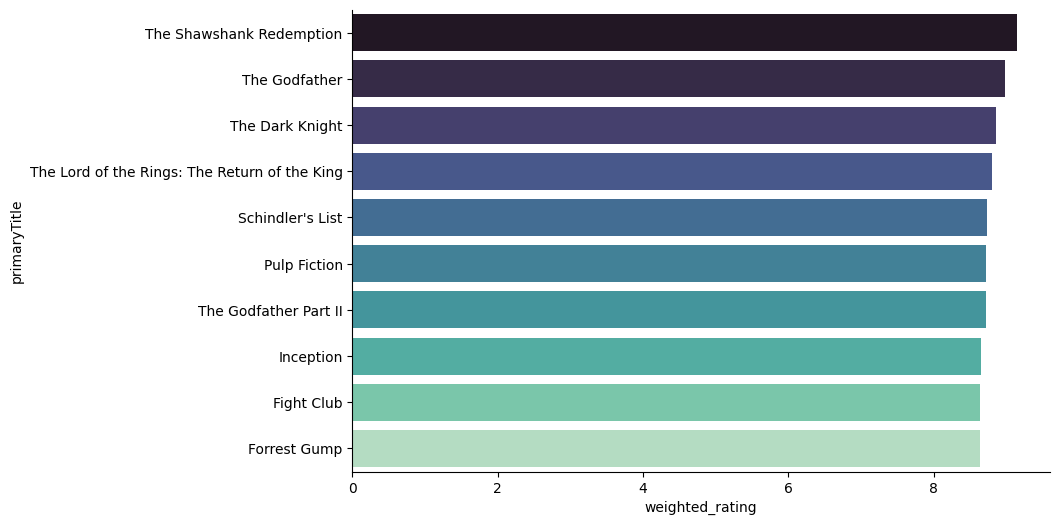

In [7]:
def weighted_rating(v,m,R,C):
    '''
    Calculate the weighted rating
    
    Args:
    v -> average rating for each item (float)
    m -> minimum votes required to be classified as popular (float)
    R -> average rating for the item (pd.Series)
    C -> average rating for the whole dataset (pd.Series)
    
    Returns:
    pd.Series
    '''
    return ( (v / (v + m)) * R) + ( (m / (v + m)) * C )

# Calcuate input parameters
C = mean(reviews['averageRating'])
m = percentile(reviews['numVotes'], 99)
R = reviews['averageRating']
v = reviews['numVotes']

# Create IMDB popular scoring
qualified_reviews = reviews[reviews['numVotes'] >= m].copy()
qualified_reviews['weighted_rating'] = weighted_rating(v,m,R,C)

# Combine Data
popular_movies = qualified_reviews.merge(movies, on = ['tconst'], how = 'inner') # Only want movies
popular_movies = popular_movies.sort_values('weighted_rating', ascending = False)

# plot the popularity based on the weighted score
fix, ax = subplots(figsize=(9,6))
barplot(data = popular_movies.head(10),
            y = 'primaryTitle',
            x = 'weighted_rating',
            palette = 'mako')
despine()

## Content-based Filtering

Using the IMDB dataset and the [spare_dot_topn](https://github.com/ing-bank/sparse_dot_topn) library, we are able to leverage quick, more relevant movies based on a single selection of movie from the user.

As a comparison, using the scikit-learn's cosine similarity takes up to 5 minutes to complete the following computations; with sparse_dot_topn, I average about 23 seconds.

The movies included are US movies that are in the top 70% of the ratings.

The filtering is primarily based on two criteria: genre and year (broken in decades).

Lastly, the last cell provides a simple I/O for users to search for movies; the system will then recommend 20 movies that are similar.

**Reference**

[Building a movie content based recommender using tf-idf](https://towardsdatascience.com/content-based-recommender-systems-28a1dbd858f5)

In [8]:
def binning_and_ohe(col, bin_size, max_bin=None):
    max_bin = col.max() + bin_size if max_bin is None else max_bin    
    bins = range(round(col.min(), -1), max_bin, bin_size)
    labels = [f'{bins[i]}-{bins[i+1] if i < len(bins) else None}' for i in range(len(bins)-1)]
    bins = cut(col, bins, labels=labels, include_lowest=True)
    return get_dummies(bins)

def filter_col(col_name, pctile):
    # rated_movies = reviews.loc[reviews['tconst'].isin(movies['tconst'])].copy()
    # Remove movies with low value in this column
    min_col_val = percentile(reviews[col_name], pctile)
    return reviews[reviews[col_name] >= min_col_val]

def get_matches_df(sparse_matrix, name_vector, name_vector_2=None, top=100):
    non_zeros = sparse_matrix.nonzero()
    
    sparserows = non_zeros[0]
    sparsecols = non_zeros[1]

    if top:
        nr_matches = top
    else:
        nr_matches = sparsecols.size
    
    left_side = empty([nr_matches], dtype=object)
    right_side = empty([nr_matches], dtype=object)
    similairity = zeros(nr_matches)
    
    name_vector_2 = name_vector_2 if name_vector_2 is not None else name_vector
    
    for index in range(0, nr_matches):
        left_side[index] = name_vector.iloc[sparserows[index]]
        right_side[index] = name_vector_2.iloc[sparsecols[index]]
        similairity[index] = sparse_matrix.data[index]
    
    return DataFrame({
        'left_side': left_side,
        'right_side': right_side,
        'similairity': similairity
    })

In [9]:
# preprocessing
rated_movies = movies.loc[movies['tconst'].isin(reviews['tconst'])].copy()
rated_movies = rated_movies.dropna(subset=['genres', 'startYear', 'runtimeMinutes'])

# # Combine Data
# popular_movies = qualified_reviews.merge(rated_movies, on = ['tconst'], how = 'inner') # Only want movies

# extract the genre
genre = rated_movies['genres'].str.split(",", expand=True)

# get all possible genre
all_genre = set()
for c in genre.columns:
    distinct_genre = genre[c].str.lower().str.strip().unique()
    all_genre.update(distinct_genre)
all_genre.remove(None)

# create item-genre matrix
genre_ohe = rated_movies[['tconst', 'genres']].copy()
genre_ohe['genres'] = genre_ohe['genres'].str.lower().str.strip()

# OHE the genres column
for genre in all_genre:
    genre_ohe[genre] = where(genre_ohe['genres'].str.contains(genre), 1, 0)
genre_ohe = genre_ohe.drop(['genres'], axis=1)
genre_ohe = genre_ohe.set_index('tconst')

# Calculate start year OHE
# using OHE for startYear because this will work better for cosine similarity
start_year = rated_movies.set_index('tconst')['startYear']
start_year = binning_and_ohe(start_year, 10)

# Runtime proved unhelpful
# runtime = rated_movies.set_index('tconst')['runtimeMinutes']
# runtime = binning_and_ohe(runtime, 30, 300)

item_mat = genre_ohe.merge(start_year, left_index=True, right_index=True)
# item_mat = item_mat.merge(runtime, left_index=True, right_index=True)

# Remove movies with low ratings for recommendations
top_ratings = filter_col('averageRating', 90)

# Remove movies with low votes for recommendations
top_votes = filter_col('numVotes', 90)

rating_mask = item_mat.index.isin(top_ratings['tconst'])
votes_mask = item_mat.index.isin(top_votes['tconst'])
                                
item_mat_2 = item_mat[rating_mask & votes_mask]

# compute similarity matix
all_movies_mat = csr_matrix(item_mat).astype(float32)
high_rating_and_votes_movies_mat = csr_matrix(item_mat_2)

transposed_matrix = high_rating_and_votes_movies_mat.transpose().astype(float32)
top_matches = awesome_cossim_topn(all_movies_mat, transposed_matrix, 20, .5, use_threads=True, n_jobs=2, )

# Retrieve all matches from top movies dataframe
matches = get_matches_df(top_matches, item_mat.reset_index()['tconst'], item_mat_2.reset_index()['tconst'], top=None)

In [10]:
def get_match(movie_title):
    test_movie = popular_movies[popular_movies['primaryTitle'].str.lower() == movie_title.lower()]
    if len(test_movie) == 0:
        test_movie = popular_movies[popular_movies['primaryTitle'].str.lower().str.contains(movie_title.lower())]
    
    test_movie = test_movie['tconst'].iloc[0]

    test_matches = matches[matches['left_side'] == test_movie]['right_side']
    test_matches = test_matches.to_list() + [test_movie]

    return movies[movies['tconst'].isin(test_matches)]

response = ""
title_error = False
while True:
    try:
        
        if title_error:
            print("This title was not found in our system. Please enter a different movie title.")
        print('Please enter a movie name. If this movie is in our database, we will provide a list of similar movies. To quit, enter "quit".')
        
        response = input()
        if response.lower() == "quit":
            break
        
        clear_output()
        movie_match = get_match(response)
        
        print(f"The following are movies that match {response}")
        display(movie_match)
        
        title_error = False
        
    except IndexError:
        title_error = True
        
    except KeyboardInterrupt:
        break

The following are movies that match 


,tconst,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genres
108636,tt0111161,movie,The Shawshank Redemption,0,1994,142,Drama
183216,tt0190332,movie,"Crouching Tiger, Hidden Dragon",0,2000,120,"Action,Adventure,Drama"
183871,tt0191043,movie,The Color of Paradise,0,1999,90,"Drama,Family"
187788,tt0195231,movie,Satya,0,1998,170,"Action,Crime,Drama"
192274,tt0200087,movie,Sarfarosh,0,1999,174,"Action,Drama,Thriller"
200697,tt0209180,movie,Sky Hook,0,2000,95,"Drama,War"
202354,tt0210945,movie,Remember the Titans,0,2000,113,"Biography,Drama,Sport"
205207,tt0213969,movie,Padaiyappa,0,1999,181,"Action,Comedy,Drama"
211470,tt0220656,movie,Mudhalvan,0,1999,169,"Action,Drama,Thriller"
211635,tt0220832,movie,Vaastav: The Reality,0,1999,145,"Action,Crime,Drama"


Please enter a movie name. If this movie is in our database, we will provide a list of similar movies. To quit, enter "quit".
